In [144]:
%matplotlib inline
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
sns.set_style('dark')

In [6]:
ticker = yf.Ticker('^SPX')

In [39]:
option_expiries = ticker.options
sorted_expiries = {int(expiry.replace('-', '')): expiry for expiry in option_expiries}
closest = list(sorted_expiries.keys())
closest.sort()
','.join([str(exp) for exp in closest])

'20191007,20191009,20191011,20191014,20191016,20191018,20191021,20191023,20191025,20191028,20191030,20191031,20191101,20191104,20191106,20191108,20191111,20191115,20191122,20191129,20191206,20191220,20191231,20200117,20200131,20200221,20200228,20200320,20200331,20200619,20200630,20200918,20200919,20200930,20201016,20201120,20201218,20210618,20211217,20260320'

In [84]:
expiry = closest[15]

In [85]:
opts = ticker.option_chain(sorted_expiries[expiry])
df_calls = opts.calls
df_puts = opts.puts
df_calls['optionType'] = 'Calls'
df_puts['optionType'] = 'Puts'
df = pd.concat([df_calls, df_puts])
df.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType
0,SPXW191108C02720000,1568606895,2720.0,300.25,224.0,236.0,0.000000,0.000000,NaN,215.0,0.252258,True,REGULAR,USD,Calls
1,SPXW191108C02740000,1570421082,2740.0,206.05,206.3,218.1,0.000000,0.000000,NaN,NaN,0.245857,True,REGULAR,USD,Calls
2,SPXW191108C02765000,1570464450,2765.0,202.68,184.5,196.4,38.199997,23.224707,15.0,NaN,0.238998,True,REGULAR,USD,Calls
3,SPXW191108C02770000,1570421082,2770.0,154.95,180.4,191.7,0.000000,0.000000,NaN,NaN,0.235870,True,REGULAR,USD,Calls
4,SPXW191108C02780000,1570421082,2780.0,125.80,171.5,183.4,0.000000,0.000000,NaN,NaN,0.233894,True,REGULAR,USD,Calls


In [86]:
df1 = pd.pivot_table(df, index=['strike'], columns=['optionType'], values=['lastPrice']).dropna().reset_index()
df1.columns = [''.join(x) for x in df1]
df1['C+P'] = df1['lastPriceCalls'] + df1['lastPricePuts']
df1['C-P+K'] = df1['lastPriceCalls'] - df1['lastPricePuts'] + df1['strike']
atmf_strike = df1.loc[df1['C+P'] == df1['C+P'].min(), 'strike'].values[0]
print(atmf_strike)
display(df[df['strike'] == atmf_strike])
ootms = df[((df['strike'] >= atmf_strike) & (df['optionType'] == 'Calls')) | ((df['strike'] <= atmf_strike) & (df['optionType'] == 'Puts'))]
implied_vols = pd.pivot_table(ootms, index='strike', values='impliedVolatility', aggfunc='mean')
implied_vols.reset_index().head()

2885.0


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType
20,SPXW191108C02885000,1570040920,2885.0,58.0,92.3,93.2,0.000000,0.000000,NaN,1.0,0.179383,True,REGULAR,USD,Calls
88,SPXW191108P02885000,1570471061,2885.0,31.8,39.0,39.8,-4.600002,-12.637368,1.0,359.0,0.180649,False,REGULAR,USD,Puts


,strike,impliedVolatility
0,1600.0,0.611332
1,1700.0,0.554692
2,1800.0,0.537114
3,1850.0,0.500005
4,1900.0,0.489263


In [201]:
T = (dt.datetime.strptime(str(expiry), '%Y%m%d') - dt.datetime.today()).days / 365

atmf_vols = implied_vols[implied_vols.index == atmf_strike]
atmf_vol = atmf_vols.values[0][0]
print('ATMF vol for time T ({:0.4f} years) is {:0.4f}'.format(T, atmf_vol))

ATMF vol for time T (0.0822 years) is 0.1800


In [157]:
def piv4(z, vol, skew, smile, power):
    A = 1 + skew / power * z
    B = (power - 1) / power * skew ** 2
    C = (smile - B) * z ** 2
    return vol * (0.5 * A + np.sqrt(0.25 * A ** 2 + 0.5 / power * C)) ** (power / 2)

,VOL,SKEW,SMILE,POWER
0.082192,0.169606,-0.549255,0.215703,1.24384


z,-10.000000,-9.551724,-9.103448,-8.655172,-8.206897,-7.758621,-7.310345,-6.862069,-6.413793,-5.965517,-5.517241,-5.068966,-4.620690,-4.172414,-3.724138,-3.275862,-2.827586,-2.379310,-1.931034,-1.482759,-1.034483,-0.586207,-0.137931,0.310345,0.758621,1.206897,1.655172,2.103448,2.551724,3.000000
vol,0.538009,0.524946,0.511687,0.49822,0.484532,0.470612,0.456444,0.442012,0.427297,0.412281,0.396939,0.381247,0.365177,0.348695,0.331766,0.314349,0.296398,0.277868,0.258709,0.238887,0.218401,0.197347,0.176075,0.155526,0.137742,0.125468,0.119704,0.118845,0.120853,0.124407


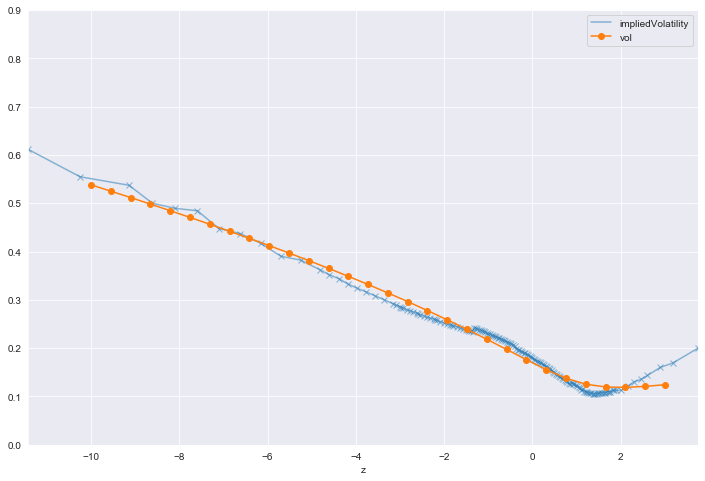

In [206]:
market_vols = implied_vols.reset_index()
market_vols['Z'] = np.log(market_vols['strike'] / atmf_strike) / (atmf_vol * np.sqrt(T))
popt, _ = curve_fit(piv4, market_vols['Z'], market_vols['impliedVolatility'])
display(pd.DataFrame([popt], columns=['VOL', 'SKEW', 'SMILE', 'POWER'], index=[T]))

piv_data = pd.DataFrame([[z, piv4(z, *popt)] for z in np.linspace(-10, 3, 30)], columns=['z', 'vol'])
display(piv_data.set_index('z').T)
fig, ax = plt.subplots()
market_vols[['Z', 'impliedVolatility']].set_index('Z').plot(grid=True, marker='x', ax=ax, alpha=0.5)
piv_data.set_index('z').plot(marker='o', grid=True, ylim=(0, 0.90), figsize=(12, 8), ax=ax);